In [ ]:

from main import *
config = OmegaConf.load("config.yaml")
torch.set_grad_enabled(False)


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    return model

model = load_model_from_config(
    config, "./models/ldm/stable-diffusion-v1/model.ckpt", verbose=True
)

In [3]:
# some helpers

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

@torch.no_grad()
def decode_and_show_image(sample):

    sample = model.decode_first_stage(sample)
    img = make_grid(sample, normalize=True, value_range=(-1, 1)).cpu()

    plt.imshow(img.permute(1, 2, 0))

@torch.no_grad()
def get_texttensors():

    c = model.get_learned_conditioning(["Large Cat", "Tiny Cute cat", "White Cat"])
    uc = model.get_learned_conditioning(len(c) * [""])

    return c, uc
        

In [19]:
for param in model.model.parameters():
    param.requires_grad = False

device = "cuda:0"
model.to(device)
model.eval()

c, uc = get_texttensors()


import time
import pandas as pd

score_df = pd.DataFrame(columns = ["Mode", "Time"])

tmp_x, tmp_c, tmp_t = torch.randn(3, 4, 64, 64).to(device), c.to(device), torch.randint(0, 5, (3,)).to(device)

Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]
/tmp/ipykernel_102714/1051631243.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



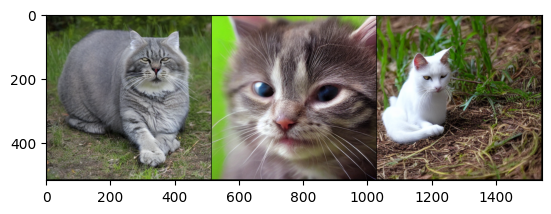

In [21]:


## Simple full precision sampling
# warm up
for i in range(3):
    model.apply_model(tmp_x, tmp_t, tmp_c)

start = time.time()
sample_scaled, _ = model.sample_log(
    cond=c,
    batch_size=3,
    ddim=True,
    ddim_steps = 50,
    unconditional_guidance_scale=5.0,
    unconditional_conditioning=uc)

end = time.time()

score_df = score_df.append({"Mode": "Baseline Full Precision", "Time": end-start}, ignore_index=True)

decode_and_show_image(sample_scaled)


Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:11<00:00,  4.25it/s]
/tmp/ipykernel_102714/3604578821.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



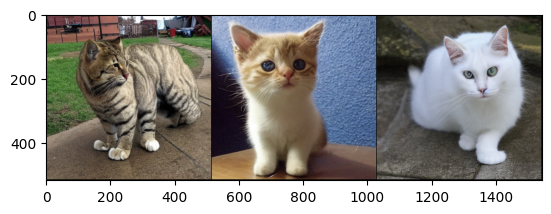

In [25]:
# AMP 

start = time.time()
with torch.autocast("cuda"):
    sample_scaled, _ = model.sample_log(
        cond=c,
        batch_size=3,
        ddim=True,
        ddim_steps = 50,
        unconditional_guidance_scale=5.0,
        unconditional_conditioning=uc)

end = time.time()

score_df = score_df.append({"Mode": "AMP without Fusion", "Time": end-start}, ignore_index=True)

decode_and_show_image(sample_scaled)



Now here, stuff isn't so simple... You have to make custom DDIM sampler that has jit with it. Luckily, it *is* simple if you are lazily going to replace the model's method with jit function. So,to actually get it to work, we can simply subsititute the model's `apply_model` function to our nvFuser Traced function.
First Let's load the jit compiled model.

In [26]:
sd_fused = torch.jit.load("sd_amp_traced.pt")
sd_fused = sd_fused.to("cuda:0")

model.apply_model = lambda x, t, c : sd_fused(_x = x, _t = t, _cnd = c)
# warmup
for i in range(3):
    model.apply_model(tmp_x, tmp_t, tmp_c)

# delete the original model
del model.model # lol


Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:08<00:00,  6.21it/s]
/tmp/ipykernel_102714/3801541644.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



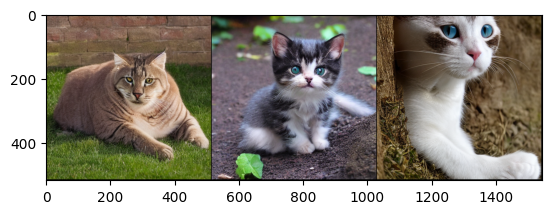

In [29]:

start = time.time()
sample_scaled, _ = model.sample_log(
    cond=c,
    batch_size=3,
    ddim=True,
    ddim_steps = 50,
    unconditional_guidance_scale=5.0,
    unconditional_conditioning=uc)
end = time.time()

score_df = score_df.append({"Mode": "AMP with Fusion", "Time": end-start}, ignore_index=True)

decode_and_show_image(sample_scaled)

In [36]:
score_df.to_csv("score.csv", index=False)

import plotly.express as px

fig = px.box(
    score_df,
    x="Mode",
    y="Time",
    title="Time taken, 3 Images, DDIM 50 iterations, Stable Diffusion Denoiser, RTX 3090",
    color="Mode",
)

fig.show()